# LocaleDB: Multivariate Time Series Clustering
---

Clustering attempts to suggest patterns in data by grouping similar items together.  This notebook uses two centroid and one message passing clustering models to demonstrate multivariate time series (MVTS) clustering of Covid-19 disease dynamics (specifically daily counts of confirmed cases and deaths reported on US county level).

## Environment
---

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

from localedb.localedb import LocaleDB
from localedb.util import plot_init, plot_series, plot_ts
from localedb.clustering import cluster_aff_prop, cluster_kmeans, cluster_kmedoids, dist_mat, plot_cluster_centers_kmeans, plot_cluster_centers_kmedoids, plot_ts_clusters_sample, plot_ts_clusters_all

db = LocaleDB().set_disease('COVID-19')

First, we declare variables and define convenience functions:

In [3]:
k = 4                           # the number of clusters to request when clustering
dis_dyn = ['n_conf', 'n_dead']  # disease dynamics time series

def get_data(fips='42___', cols=dis_dyn, day0=0, day1=99999, do_interpolate=True, n_diff=0, smooth_window_len=14):
    return np.array(db.get_dis_dyn_by_fips(fips, cols, day0, day1, do_interpolate, n_diff, smooth_window_len, do_scale=True)[0])

## PA: Five Counties
---

Here, we cluster five clusters from the state of PA on the observed disease dynamics.  We begin by pulling the data from the database:

In [4]:
ds_test   = get_data('4200_', n_diff=0, smooth_window_len=14)  # standardized
ds_test_d = get_data('4200_', n_diff=1, smooth_window_len=28)  # standardized differenced
ds_test.shape

(5, 2, 547)

There are five counties, each has two time series of 546 observations.  The first dataset stores the raw but standardized time series, while the second one standardized and differenced.  Let's visualize both.

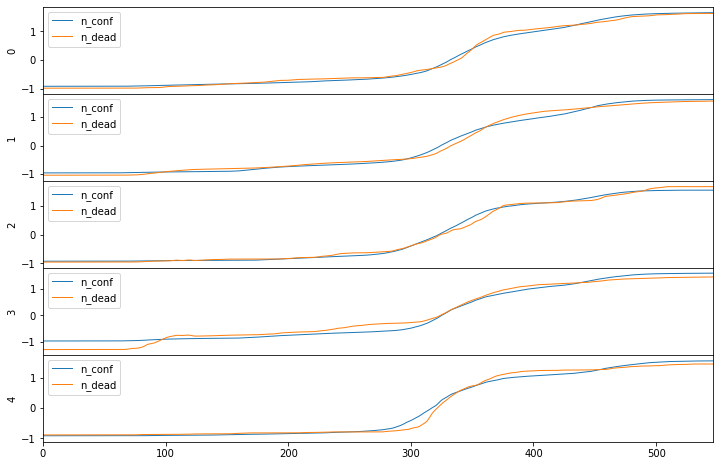

In [5]:
_,_ = plot_series(ds_test, cols=dis_dyn, figsize=(12,8))

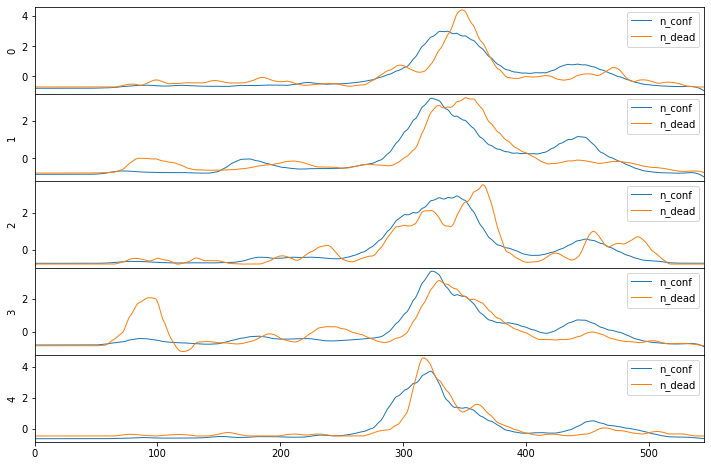

In [6]:
_,_ = plot_series(ds_test_d, cols=dis_dyn, figsize=(12,8))

Now we cluster the first dataset using the KMeans and KMedioids algorithms, print cluster assignments, and plot the central trajectories for each cluster.

[3 3 1 2 0]


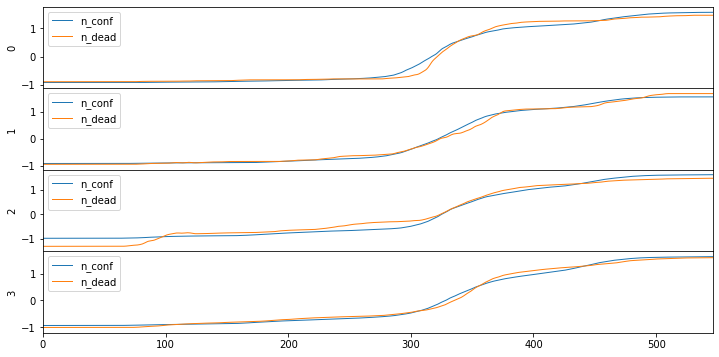

In [7]:
km = cluster_kmeans(ds_test, k, random_state=0)
print(km.labels_)
plot_cluster_centers_kmeans(km, cols=dis_dyn, figsize=(12,6))
del(km)

[3 3 1 2 0]


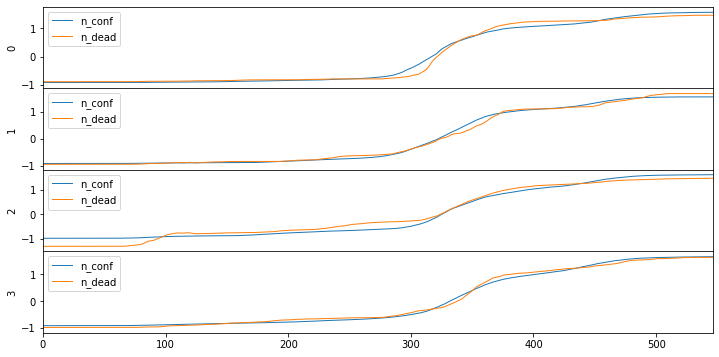

In [8]:
km = cluster_kmedoids(ds_test, k, random_state=0)
print(km.labels_)
plot_cluster_centers_kmedoids(km, ds_test.shape[1], cols=dis_dyn, figsize=(12,6))
del(km)

Time to move on to a bigger dataset.

## PA: All 67 Counties
---

Now, we will take a look at all 67 counties of PA.

In [9]:
ds_pa   = get_data('42___', n_diff=0, smooth_window_len=14)
ds_pa_d = get_data('42___', n_diff=1, smooth_window_len=28)

Let's plot the differenced time series because changes in dynamics are easier to see then.  Evidently, Covid-19 disease dynamics varies substaintially across the counties.

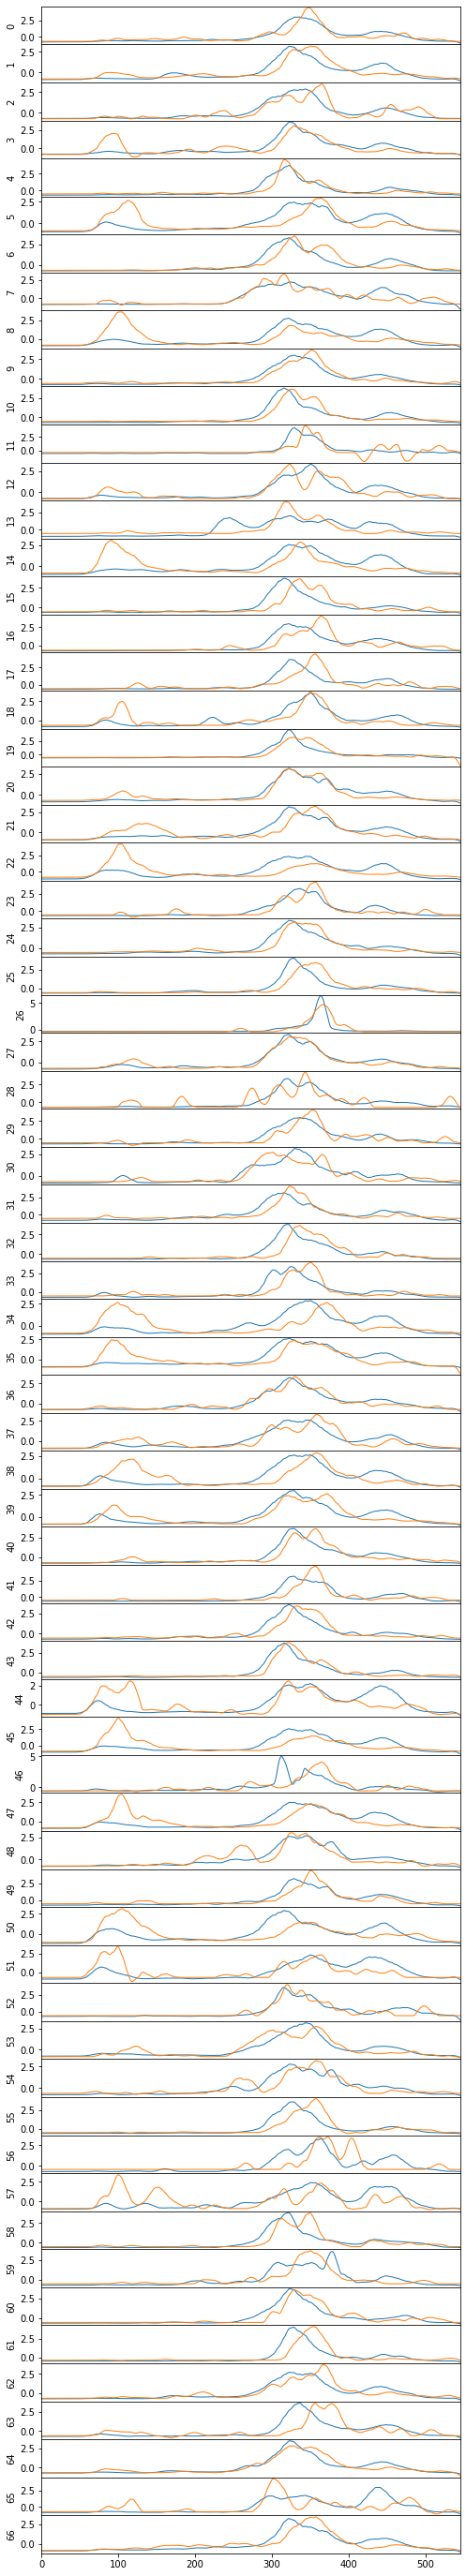

In [10]:
_,_ = plot_series(ds_pa_d, figsize=(8,50), do_legend=False)

Like before, we can quickly cluster these 67 counties using KMeams:

[2 2 3 2 3 0 3 3 0 3 3 1 2 3 0 3 1 1 2 3 2 2 0 1 3 1 1 2 2 1 3 3 1 3 0 0 3
 2 0 2 1 1 3 3 0 0 1 0 2 1 0 0 3 2 3 1 1 0 3 1 1 1 1 1 3 2 2]


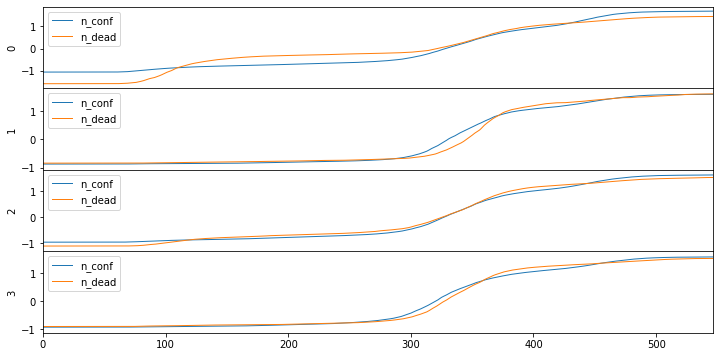

In [11]:
km = cluster_kmeans(ds_pa, k, random_state=0)
print(km.labels_)
plot_cluster_centers_kmeans(km, cols=dis_dyn, figsize=(12,6))
del(km)

Let's change the distance metric from the Euclidian (which is usally the default) to soft-DTW (i.e., soft Dynamic Time Warping).  Because we will use the distance matrix later on, we store the reference to it in a variable.  For more information on soft-DTW see the original [publication](https://arxiv.org/abs/1703.01541) and the relevant parts of the documentation of the `tslearn` package which is used under the hood [here](https://tslearn.readthedocs.io/en/stable/user_guide/dtw.html#soft-dtw) and [here](https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_softdtw_path.html#sphx-glr-auto-examples-metrics-plot-softdtw-path-py).

In [12]:
d = dist_mat(ds_pa, metric='softdtw')
clustering_km = cluster_kmedoids(d, k, metric='precomputed')

Using a useful convenience function, we can plot several random time series from the selected number of cluster.  Below, we plot a random sample of three multivariate time series for every cluster.

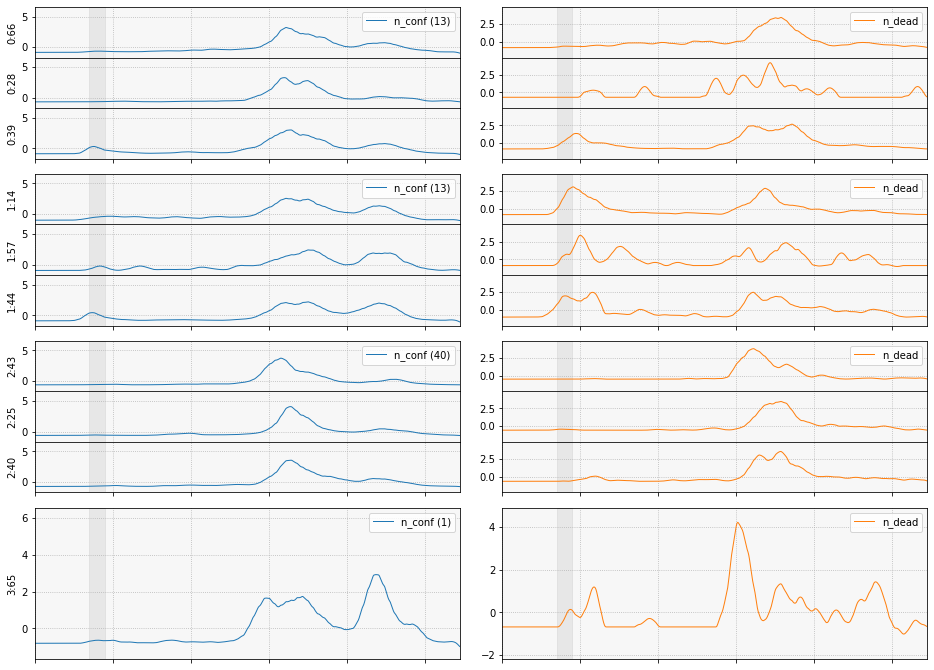

In [13]:
_ = plot_ts_clusters_sample(ds_pa_d, clustering_km.labels_, 3, 0, dis_dyn, True, True, ':', 8, 1, highlight_rect_xw=[(70,20)])

We can also plot all the time series like so (we could plot them in a single column as well):

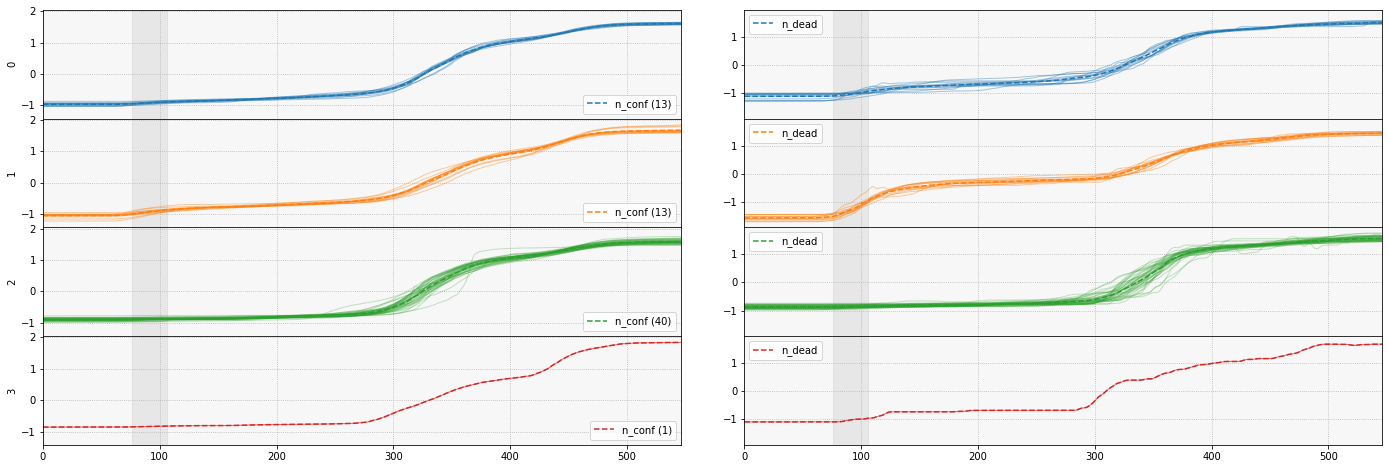

In [14]:
_ = plot_ts_clusters_all(ds_pa, clustering_km.labels_, 0, dis_dyn, None, True, True, True, True, ':', 12, 2, highlight_rect_xw=[(76,30)])

And here's how the corresponding differenced time series look like when plotted based on the same cluster assignment:

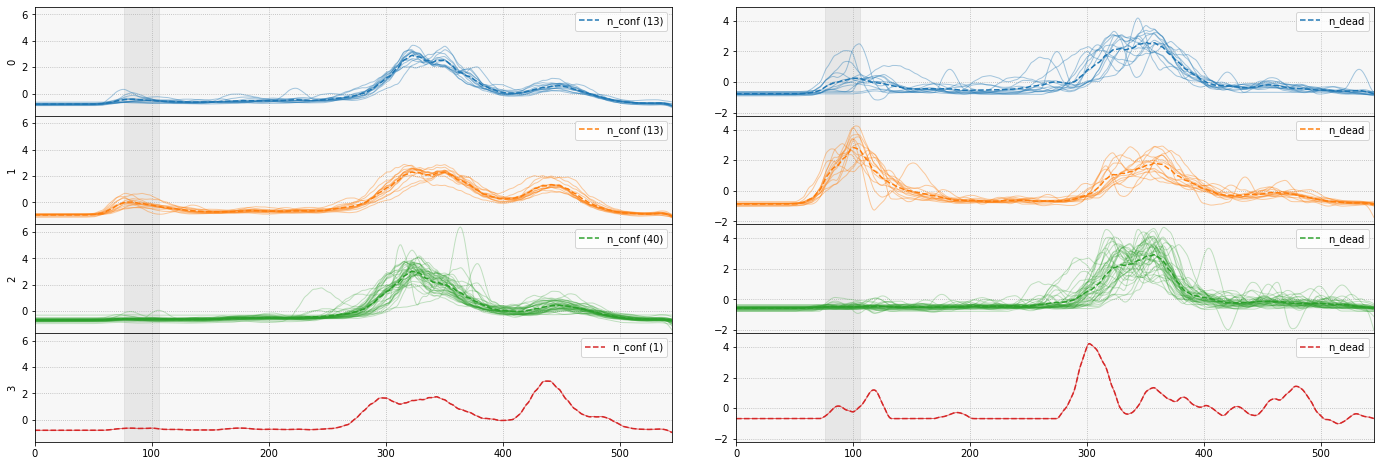

In [15]:
_ = plot_ts_clusters_all(ds_pa_d, clustering_km.labels_, 0, dis_dyn, None, True, True, True, True, ':', 12, 2, highlight_rect_xw=[(76,30)])

We finish by using affinity propagagion clustering alogorithm which does not require us to specify the number of clusters (the algorithm will suggest two clusters).  We use the previously computed distance matrix.

In [16]:
clustering_ap = cluster_aff_prop(d)

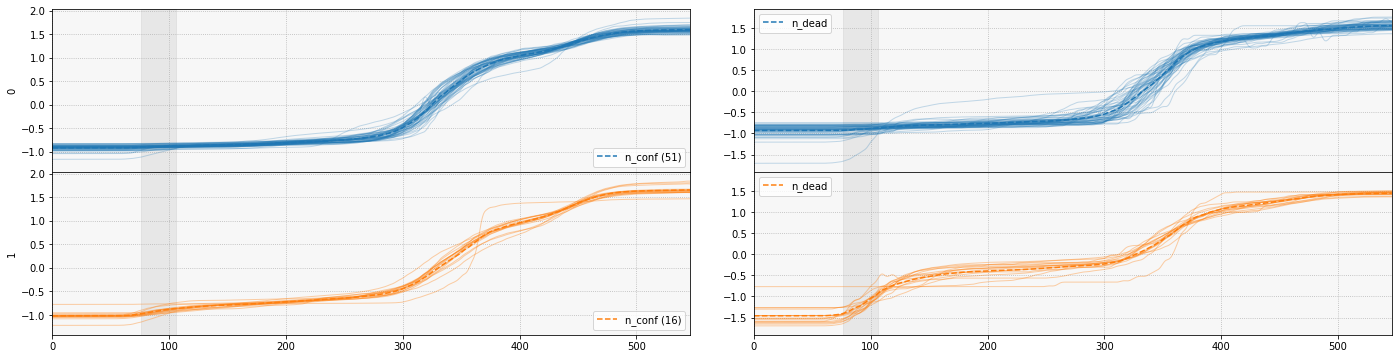

In [17]:
_ = plot_ts_clusters_all(ds_pa, clustering_ap.labels_, 0, dis_dyn, None, True, True, True, True, ':', 12, 3, highlight_rect_xw=[(76,30)])

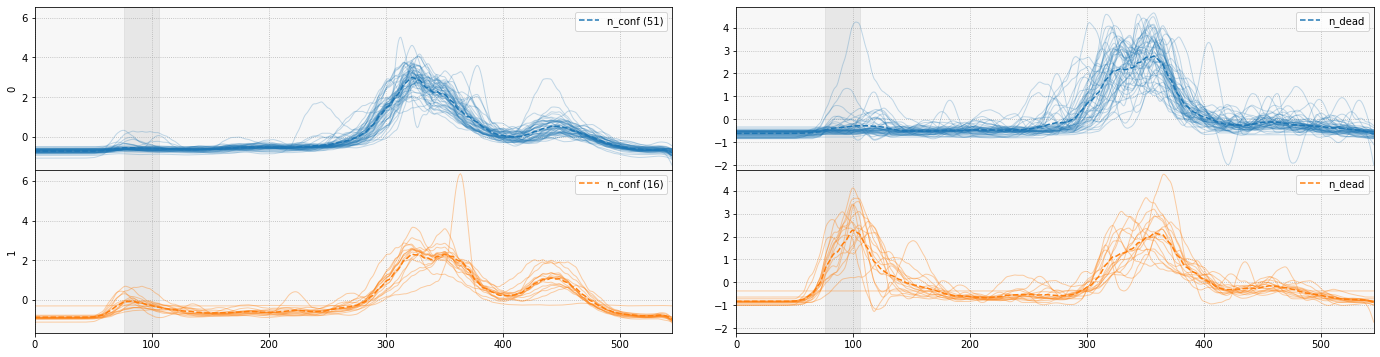

In [18]:
_ = plot_ts_clusters_all(ds_pa_d, clustering_ap.labels_, 0, dis_dyn, None, True, True, True, True, ':', 12, 3, highlight_rect_xw=[(76,30)])

We finish with a proper cleanup:

In [19]:
del(clustering_km, clustering_ap, d, ds_pa, ds_pa_d, db)